In [1]:
%load_ext autoreload
%autoreload 2

## import

In [1]:
from IPython.display import clear_output

#import plotly 
#import plotly.graph_objects as go

import matplotlib
import matplotlib.ticker as mticker
import matplotlib.dates as mdates
import tensorflow.keras as keras
import matplotlib.pyplot as plt
import tensorflow as tf
import yfinance as yf
import datetime as dt
#import seaborn as sns
import pandas as pd
import numpy as np
import talos as ta
import math
import time
import sys
import os

from sklearn import preprocessing
from sklearn.metrics import confusion_matrix, classification_report, matthews_corrcoef
from sklearn.metrics import mean_squared_error, roc_auc_score, r2_score
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
from talos.utils.gpu_utils import parallel_gpu_jobs
from talos.model.normalizers import lr_normalizer
#from matplotlib.dates import bytespdate2num
from matplotlib import style
from time import time

from keras.models import Sequential, Model, load_model
from keras.layers.core import Dense, Dropout, Activation, Flatten, Permute, Reshape
from keras.callbacks import Callback, ModelCheckpoint, ReduceLROnPlateau, CSVLogger
from keras.layers.convolutional import Conv1D, Conv2D, MaxPooling1D, MaxPooling2D
from keras.layers import Embedding, Input, SpatialDropout1D
#from keras.layers.convolutional import AtrousConvolution1D
from keras.layers import GlobalMaxPooling1D, RepeatVector, AveragePooling1D
from keras.layers.wrappers import Bidirectional, TimeDistributed
from keras.optimizers import RMSprop, Adam, SGD, Nadam, Adamax
from keras.utils import plot_model, np_utils, to_categorical
from keras.layers.normalization import BatchNormalization
from keras.layers.recurrent import LSTM, GRU, SimpleRNN
from keras.layers.advanced_activations import *
from keras.initializers import *
from keras.constraints import *
from keras import backend as K
from keras import regularizers
from keras import losses

# Carica dati

In [2]:
bitcoin_storico1 = '../bitcoin/Binance_BTCUSDT_d.csv'
df_bitcoin = pd.read_csv(bitcoin_storico1, skiprows=1)
df_bitcoin['Date'] = pd.to_datetime(df_bitcoin['Date'])
df_bitcoin.sort_values('Date', inplace=True)

In [3]:
df_bitcoin['Date']

1179   2017-08-17
1178   2017-08-18
1177   2017-08-19
1176   2017-08-20
1175   2017-08-21
          ...    
4      2020-11-16
3      2020-11-17
2      2020-11-18
1      2020-11-19
0      2020-11-20
Name: Date, Length: 1180, dtype: datetime64[ns]

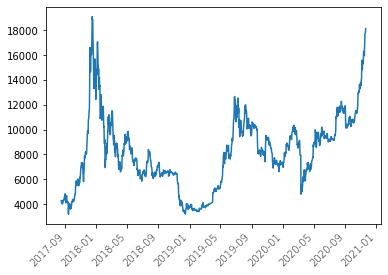

In [4]:
plt.plot(df_bitcoin['Date'], df_bitcoin['Close'])
plt.xticks(
    rotation=45,
    horizontalalignment='right',
    fontweight='light',
    fontsize='medium',
);

In [5]:
from nsp_utils import simple_func, find_result, find_gap, find_hldif, find_emad, find_stoch, find_volat, create_Xt_Yt

In [7]:
data_original = df_bitcoin.set_index('Date')
data_original['Volume'] = data_original['Volume BTC']

WINDOW = 32   #@param {type:"slider", min:10, max:90, step:10}
EMB_SIZE = 8  # колич. входных перем.
#@markdown The size of the test data.
PERCENT = 0.2   #@param {type:"slider", min:0, max:1, step:0.05}
STEP = 1      # шаг
#@markdown Prediction Range (in days).
FORECAST = 1

#@markdown Period of Fast EMA
fast_emad = 8 #@param {type:"slider", min:1, max:16, step:1}
#@markdown Period of Slow EMA
slow_emad = 18 #@param {type:"slider", min:1, max:32, step:1}
#@markdown K period for the stochastic oscillator
k_stoch = 5 #@param {type:"slider", min:1, max:16, step:1}
#@markdown Smoothing Period for Stochastic Oscillator
smooth_stoch = 3 #@param {type:"slider", min:1, max:8, step:1}
#@markdown Volatility Calculation Period
period_volat = 6 #@param {type:"slider", min:1, max:16, step:1}
#@markdown Autocorrelation period
window_autocorr = 30 #@param {type:"slider", min:10, max:90, step:5}
#@markdown Autocorrelation lag
lag_autocorr = 4 #@param {type:"slider", min:1, max:10, step:1}

data_original['log_ret'] = np.log(data_original['Close']).diff()
data_original['Autocorr'] = data_original['log_ret'].rolling(window=window_autocorr, min_periods=window_autocorr, 
                                                             center=False).apply(lambda x: x.autocorr(lag=lag_autocorr), raw=False)

new_data = pd.DataFrame(np.sort(data_original.index, axis=0), columns=['Date'])

# Calculate additional parameters and normalize the data

In [8]:
# заполняем расчетную таблицу
new_data['AUTCOR'] = simple_func(data_original['Autocorr'])
new_data['GAP'] = find_gap(data_original)
new_data['HLDIF'] = find_hldif(data_original)
new_data['CLOSE'] = simple_func(data_original['Close'])
new_data['VOLUME'] = simple_func(data_original['Volume'])
new_data['EMAD'] = find_emad(data_original, fast_emad, slow_emad)
new_data['STOCH'] = find_stoch(data_original, k_stoch, smooth_stoch)
new_data['VOLAT'] = find_volat(data_original, period_volat)
del data_original["log_ret"]
del data_original["Autocorr"]

# определяем количество удаляемых строк
lishnee = [fast_emad, slow_emad, k_stoch, smooth_stoch, period_volat, k_stoch+smooth_stoch-1, window_autocorr+1, lag_autocorr]
lishnee = pd.DataFrame(lishnee)
row_del = int(lishnee.max())

# удаляем пустые строки
new_data = new_data[row_del-1:]
new_data.reset_index(inplace=True)
del new_data["index"]
# заменяем пустые данные нулем
new_data = new_data.fillna(0)

# --- Нормализация данных ---
min_max_scaler = preprocessing.MinMaxScaler()
new_data['GAP'] = min_max_scaler.fit_transform(new_data.GAP.values.reshape(-1,1))
new_data['HLDIF'] = min_max_scaler.fit_transform(new_data.HLDIF.values.reshape(-1,1))
new_data['CLOSE'] = min_max_scaler.fit_transform(new_data.CLOSE.values.reshape(-1,1))
new_data['VOLUME'] = min_max_scaler.fit_transform(new_data.VOLUME.values.reshape(-1,1))
new_data['EMAD'] = min_max_scaler.fit_transform(new_data.EMAD.values.reshape(-1,1))
new_data['STOCH'] = min_max_scaler.fit_transform(new_data.STOCH.values.reshape(-1,1))
new_data['VOLAT'] = min_max_scaler.fit_transform(new_data.VOLAT.values.reshape(-1,1))
new_data['AUTCOR'] = min_max_scaler.fit_transform(new_data.AUTCOR.values.reshape(-1,1))

gapn = new_data.loc[:, 'GAP'].tolist()
hldifn = new_data.loc[:, 'HLDIF'].tolist()
closen = new_data.loc[:, 'CLOSE'].tolist()
volumen = new_data.loc[:, 'VOLUME'].tolist()
emadn = new_data.loc[:, 'EMAD'].tolist()
stochn = new_data.loc[:, 'STOCH'].tolist()
volatn = new_data.loc[:, 'VOLAT'].tolist()
autocorn = new_data.loc[:, 'AUTCOR'].tolist()

gapn, hldifn, closen, volumen = gapn[WINDOW:], hldifn[WINDOW:], closen[WINDOW:], volumen[WINDOW:]
emadn, stochn, volatn, autocorn = emadn[WINDOW:], stochn[WINDOW:], volatn[WINDOW:], autocorn[WINDOW:]

# выводим сводные статистичекие данные по расчетной таблице new_data
new_data.head()

,Date,AUTCOR,GAP,HLDIF,CLOSE,VOLUME,EMAD,STOCH,VOLAT
0,2017-09-16,0.625651,0.0,0.101162,0.031668,0.003183,0.318529,0.339845,0.157989
1,2017-09-17,0.629224,0.0,0.052590,0.030726,0.001681,0.318416,0.578105,0.136159
2,2017-09-18,0.460450,0.0,0.091424,0.051809,0.002555,0.331147,0.717880,0.122865
3,2017-09-19,0.440944,0.0,0.054673,0.043945,0.002235,0.336737,0.818227,0.120671
4,2017-09-20,0.440500,0.0,0.047713,0.043313,0.001789,0.341170,0.819390,0.057842


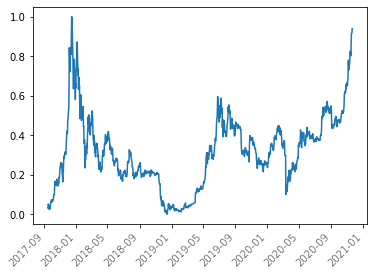

In [9]:
plt.plot(new_data['Date'], new_data['CLOSE'])
plt.xticks(
    rotation=45,
    horizontalalignment='right',
    fontweight='light',
    fontsize='medium',
);

In [ ]:
### i primi livelli convnet dovrebbero leggere i dati scalati tra max e min dell'intervallo breve che hanno in input

# Pre-preparation of data for training a neural network

In [10]:
X, Y = [], []
for i in range(0, len(new_data), STEP): 
    try:
        g = gapn[i:i+WINDOW]
        h = hldifn[i:i+WINDOW]
        c = closen[i:i+WINDOW]
        v = volumen[i:i+WINDOW]
        e = emadn[i:i+WINDOW]
        s = stochn[i:i+WINDOW]
        b = volatn[i:i+WINDOW]
        a = autocorn[i:i+WINDOW]

        y_i = closen[i+WINDOW+FORECAST]  
        x_i = np.column_stack((g, h, c, v, e, s, b, a))

    except Exception as e:
        break

    X.append(x_i)
    Y.append(y_i)

X, Y = np.array(X), np.array(Y)
X_train, X_test, Y_train, Y_test = create_Xt_Yt(X, Y, PERCENT)

X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], EMB_SIZE))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], EMB_SIZE))

# Quick analysis (prediction and backtesting)

In [11]:
#@markdown The amount of initial capital.
CAPITAL = 10000 #@param {type:"integer"}
#@markdown The share of capital to which we open the order.
CHAST = 0.05 #@param {type:"slider", min:0.05, max:1, step:0.05}
#@markdown The size of the commission for opening/closing an order (%).
commissioni = 0.1 #@param {type:"slider", min:0, max:1, step:0.05}


# Train

In [14]:
from model import create_model

In [35]:
model = create_model(WINDOW, EMB_SIZE, learning_rate=0.000005)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.7, patience=5000, min_lr=0.0000001, verbose=0)
checkpointer = ModelCheckpoint(filepath="test.hdf5", verbose=0, save_best_only=True)
history = model.fit(X_train, Y_train, 
              epochs = 100000, 
              batch_size = 512, 
              verbose=0, 
              validation_data=(X_test, Y_test),
              callbacks=[checkpointer,reduce_lr],
              shuffle=True)

In [45]:
# Carica un modello già addestrato
#model.load_weights("weights.h5")

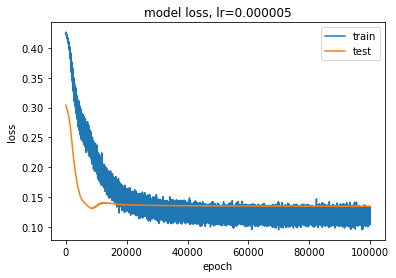

In [36]:
plt.figure()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss, lr=0.000005')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='best')
plt.savefig('lr_0.000005_reduce-lr_model_big1.jpg')
plt.show()

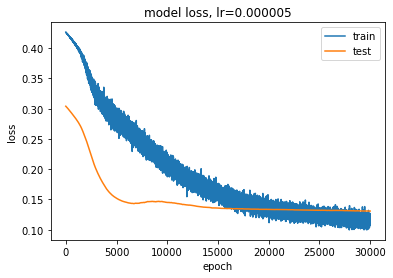

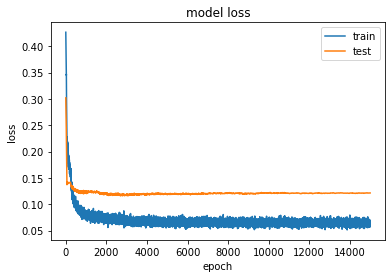

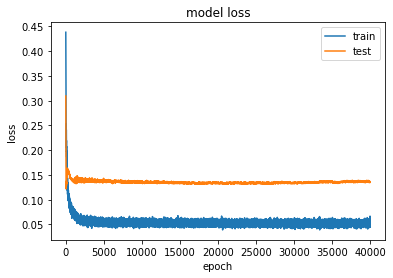

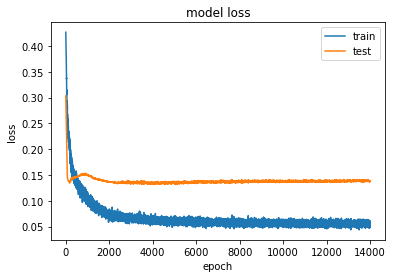

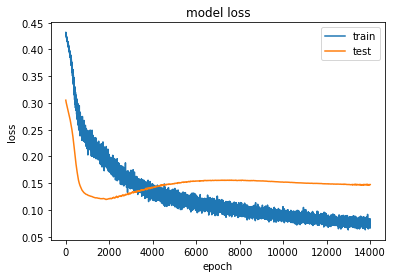

<Figure size 432x288 with 0 Axes>

In [32]:
pred = model.predict(X_test)
predicted = pred
original = Y_test

In [33]:
predic = pd.DataFrame(predicted)
fact = pd.DataFrame(original)
itog = pd.concat([predic, fact], axis=1)
itog.columns = (['pred', 'fact'])
itog["predUD"] = find_result(predic)
itog["factUD"] = find_result(fact)

true_long = 0
true_short = 0
vern = 0

for i in range(0,len(itog)):
    if itog["predUD"][i] > 0.5 and itog["factUD"][i] > 0.5:
        true_long = true_long + 1
    elif itog["predUD"][i] < 0.5 and itog["factUD"][i] < 0.5:
        true_short = true_short + 1
  
    if itog["predUD"][i] == itog["factUD"][i]:
        vern = vern + 1
    
per_long = round((true_long/len(itog[itog["factUD"]>0.5]))*100,2)
per_short = round((true_short/len(itog[itog["factUD"]<0.5]))*100,2)
per_vern = round((vern/len(itog))*100,2)

print("Percentage of open orders for increase:", per_long)
print("Percentage of open orders for decrease:", per_short)
print("")
print("The percentage of correct forecasts:", per_vern)
print("--------------------------------------")
itog.head()

print ("MSE =", np.mean(np.square(predicted - original)))
print ("MAE =", np.mean(np.abs(predicted - original)))
print ("MAPE =", np.mean(np.abs((original - predicted) / original)))

Percentage of open orders for increase: 48.37
Percentage of open orders for decrease: 51.11

The percentage of correct forecasts: 49.65
--------------------------------------
MSE = 0.02965888718908574
MAE = 0.13841035540342825
MAPE = inf


# Backtest

Portfolio Change: -100.0 % in 868 days


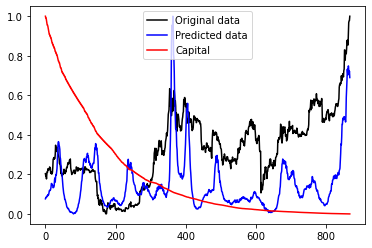

In [34]:
data_original.reset_index(inplace=True) # Вытаскиваем Дату из индекса
test_dates = pd.DataFrame(np.array(data_original["Date"][-len(Y_test):]))
test_price = pd.DataFrame(np.array(data_original["Close"][-len(Y_test):]))
data_original = data_original.set_index('Date') # устанавливаем Дату как индекс обратно
test_signal = pd.DataFrame(np.array(find_result(pd.DataFrame(pred))))
backtest = pd.concat([test_dates, test_price, test_signal], axis=1)
backtest.columns = (['Date', 'Price', 'Signal'])

balans = []
balans.append(CAPITAL)
capital_now = CAPITAL
signal_now = backtest['Signal'][0]
price_now = backtest['Price'][0]
change_now = 0.0

for i in range(1,len(backtest)):
    if signal_now == backtest['Signal'][i]: # if the current signal matches the original, then
        balans.append(capital_now) # do not change anything and rewrite current capital
    else: # if the signal has changed, then
        change_now = (backtest['Price'][i] - price_now) / price_now # calculate the price change
    if signal_now > 0.5: # if a signal to increase stock prices
        #-------------------------------
        total = capital_now * CHAST # calculate the amount to open an order
        capital_now = capital_now - total # at the opening we subtract this amount from the capital
        komis_open = total * commissioni # we calculate the commission for opening an order
        total = total + (total * change_now) #calculate the amount taking into account changes in the price of an asset
        komis_close = total * commissioni # we calculate the commission for closing an order
        total = total - komis_open - komis_close # calculate the amount minus commissions
        capital_now = capital_now + total # when closing an order, add the amount of capital
        balans.append(capital_now) # and rewrite current capital
        #-------------------------------
        signal_now = backtest['Signal'][i] #  update current signal
        price_now = backtest['Price'][i] # update current price        
    else: # if a signal to decrease stock prices
        #-------------------------------
        total = capital_now * CHAST #  calculate the amount to open an order
        capital_now = capital_now - total #at the opening we subtract this amount from the capital
        komis_open = total * commissioni #  we calculate the commission for opening an order
        total = total - (total * change_now) # calculate the amount taking into account changes in the price of an asset
        komis_close = total * commissioni # we calculate the commission for closing an order
        total = total - komis_open - komis_close # calculate the amount minus commissions
        capital_now = capital_now + total # when closing an order, add the amount of capital
        balans.append(capital_now) # and rewrite current capital
        #-------------------------------
        signal_now = backtest['Signal'][i] #  update current signal
        price_now = backtest['Price'][i] # update current price

backtest['Capital'] = pd.DataFrame(balans)
#from IPython.display import clear_output
#clear_output()

orig = pd.DataFrame(original)
perd = pd.DataFrame(predicted)
capi = pd.DataFrame(np.array(backtest['Capital']))
itog = pd.concat([orig, perd, capi], axis=1)
itog.columns = (['orig', 'perd', 'capi'])
itog['orig'] = min_max_scaler.fit_transform(itog.orig.values.reshape(-1,1))
itog['perd'] = min_max_scaler.fit_transform(itog.perd.values.reshape(-1,1))
itog['capi'] = min_max_scaler.fit_transform(itog.capi.values.reshape(-1,1))
print("Portfolio Change:", round((itog['capi'][len(itog['capi'])-1] - itog['capi'][0])*100, 1),"% in", len(itog['capi']), "days")
plt.plot(itog['orig'], color = 'black', label = 'Original data')
plt.plot(itog['perd'], color = 'blue', label = 'Predicted data')
plt.plot(itog['capi'], color = 'red', label = 'Capital')
plt.legend()
plt.show()

In [19]:
# Save the weight and architecture of the neural network
model.save_weights('weights.h5', overwrite=True)
model.save('model.h5', overwrite=True)

# Save the network architecture in JSON format
model_json = model.to_json()
json_file = open("test.json", "w")
json_file.write(model_json)
json_file.close()